# Testing unfolding -- unfold 28Si

Procedure:
- Unfold raw spectrum with ompy / mama
- Compare unfolded spectra
- Fold the unfolded spectra and compare to the raw spectrum

**Jump to**:
- [Generating raw spectra](#generate)
- [Comparison without threshold in ompy](#compare1)
- [Comparison with threshold in ompy](#compare2)- 
- [Comparison folded spectra1](#compare3) here: without removing negatives of unfolding
- [Comparison folded spectra2](#compare4) here: removing negatives of unfolding

In [1]:
%load_ext autoreload
%matplotlib notebook
%matplotlib notebook 
# %matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import sys
# sys.path.insert(0, "../../")
import ompy as om
import logging

# %matplotlib inline

%autoreload 2

### some plotting script (no need to read)

In [2]:
from typing import Union, Optional, Tuple
from scipy.ndimage import gaussian_filter1d
def plot_compare(Es: np.ndarray, exp1: om.Matrix, exp2: om.Matrix, theo: Optional[om.Matrix] = None, 
                 label1: str= None, label2: str= None, label_teo: str ="theo",
                 iscores=None,
                 rebin_Eg_factor=None):
    """
    Plots and compare matrixes the theo/simulated spectra
    """
    exp1 = exp1.copy()
    exp2 = exp2.copy()
    if theo is not None: theo = theo.copy()
        
    if rebin_Eg_factor is not None:
        for mat in [exp1, exp2]:
            mat.rebin("Eg", factor=rebin_Eg_factor)
        if theo is not None:
            theo.rebin("Eg", factor=rebin_Eg_factor)

    assert exp1.has_equal_binning(exp2)

#     fig, axmat = plt.subplots(3, 3, figsize=(10,10))
#     fig_diff, axmat_diff = plt.subplots(3, 3, figsize=(10,10))

    # prepare grid
    Nmax = 9
    fig = plt.figure(figsize=(8,8), constrained_layout=False)
    gs0 = fig.add_gridspec(3, 1)

    gs00 = gs0[0].subgridspec(2, 3, hspace=0.0)
    gs01 = gs0[1].subgridspec(2, 3, hspace=0.0)
    gs02 = gs0[2].subgridspec(2, 3, hspace=0.0)

    # gs01 = gs0[1].subgridspec(3, 2)

    ax_abs = []
    ax_diff = []

    for gs in [gs00, gs01, gs02]:
        for a in range(2):
            if a==0:
                ax_list=ax_abs
            else:
                ax_list=ax_diff
            for b in range(3):  
                ax_list.append(fig.add_subplot(gs[a, b]))

    # hacky share axes
    ax_all = fig.get_axes()
    for ax in ax_all[1:]:
        ax.get_shared_x_axes().join(ax, ax_all[0])
                
    
    if theo is None:
        lower = ("(exp1.-exp2)/exp2 in %")
    else:
        lower = ("(exp.-theo)/theo in %")
    fig.suptitle(f"/upper/: absolute numbers \n/lower/:{lower}")


    for i, E in enumerate(Es):
        if i == Nmax:
            print("Running out of axes, finish plotting")
            break
        ax = ax_abs[i]
        axdiff = ax_diff[i]
        
        Ep1 = exp1.Ex[exp1.index_Ex(E)]
        values, Eg = exp1.projection(axis="Eg", Emin=Ep1, Emax=Ep1)
        exp1_py = om.Vector(values, Eg)

        Ep2 = exp2.Ex[exp2.index_Ex(E)]
        values, Eg = exp2.projection(axis="Eg", Emin=Ep2, Emax=Ep2)
        exp2_py = om.Vector(values, Eg)

        exp1_py.plot(ax=ax, linestyle="--", label=label1)
        exp2_py.plot(ax=ax, linestyle=":", label=label2)
        
#         print(exp1_py.values.sum(), exp2_py.values.sum())
        binwidth = exp2_py.E[1] - exp2_py.E[0]
#         sigma = 
#         print(sigma/binwidth)
#         smooth.values = gaussian_filter1d(smooth.values, sigma=sigma/binwidth)
#         smooth.plot(ax=ax, label="smooth", alpha=0.3)
        if theo is None:
            diff = ((exp1_py - exp2_py))
            diff_smoothed = diff.copy()
            
            sigma = 40
            binwidth = exp2_py.E[1] - exp2_py.E[0]
            for smooth in [diff_smoothed]:
                smooth.values = gaussian_filter1d(smooth.values, sigma=sigma/binwidth)
            
            for vec in [diff, diff_smoothed]:
                vec /= exp2_py * 100
            
            diff.plot(ax=axdiff, linestyle="--", 
                           label="diff", alpha=0.25)
            diff_smoothed.plot(ax=axdiff, linestyle="--", 
                           label="diff, smoothed")
        
        else:
            Et = theo.Ex[theo.index_Ex(E)]
            values, Eg = theo.projection(axis="Eg", Emin=Et, Emax=Et)
            theo_py = om.Vector(values, Eg)
            theo_py.values = om.rebin_1D(theo_py.values, theo_py.E, exp1_py.E)
            theo_py.E = exp2_py.E
            theo_py.plot(ax=ax, label=label_teo, linestyle="-", alpha=0.5)
            
#             print(exp2_py.values.sum(), theo_py.values.sum())
#             print(exp2_py.values[10:].sum(), theo_py.values[10:].sum())
            
            ompy_diff = ((exp1_py - theo_py))
            mama_diff = ((exp2_py - theo_py))
            
            ompy_diff_smoothed = ompy_diff.copy()
            mama_diff_smoothed = mama_diff.copy()
            
            sigma = 40
            binwidth = exp2_py.E[1] - exp2_py.E[0]
            for smooth in [ompy_diff_smoothed, mama_diff_smoothed]:
                smooth.values = gaussian_filter1d(smooth.values, sigma=sigma/binwidth)
            
            for vec in [ompy_diff, ompy_diff_smoothed, mama_diff, mama_diff_smoothed]:
                vec /= theo_py * 100
            
            ompy_diff.plot(ax=axdiff, linestyle="--", 
                           label=label1, alpha=0.25)
            ompy_diff_smoothed.plot(ax=axdiff, linestyle="--", 
                           label=label1+", smoothed")
            mama_diff.plot(ax=axdiff, linestyle=":", 
                           label=label2, alpha=0.25)
            mama_diff_smoothed.plot(ax=axdiff, linestyle="--", 
                           label=label2+", smoothed")

#         ax.legend()
#         if E<0:
#             xmax = 3e3
#         else:
        xmax = E+1e3
        ax.set_yscale("log")
        ax.set_xlim(0, xmax)
        valmin = exp1_py.values[:exp1.index_Ex(E)]
#         try:
#             plotmin = valmin[valmin>0].min()*0.3
#         except ValueError:
#             plotmin = None
        plotmin = 5
        if len(valmin)==0:
            plotmax = None
        else:
            plotmax = valmin.max()*2
        ax.set_ylim(plotmin, plotmax)

        axdiff.axhline(0, color="r", alpha=0.3)
#         axdiff.legend()
        axdiff.set_xlim(0, xmax)
        axdiff.set_ylim(-30, 30)

        for a in [ax, axdiff]:
            if i == 0:
                a.legend(fontsize=8, loc="best")
#             if i < 6:
#                 a.set_xticklabels([])
#             if i % 3 != 0:
#                 a.set_yticklabels([])
            
            binwidth = exp1_py.E[1]-exp1_py.E[0]
            try:
                selected_iteration = iscores[exp2.index_Ex(E)]
                text = "{:.0f}+-{:.0f} keV\nit={}".format(Ep1, binwidth/2, selected_iteration)
            except (IndexError, TypeError):
                text = "{:.0f}+-{:.0f} keV".format(Ep1, binwidth/2)
            a.text(0.5, .5, text,
                   transform=a.transAxes, fontsize=8)
    return fig, ax_abs, ax_diff

<a id='generate'></a>
## Generating the raw spectra

<IPython.core.display.Javascript object>


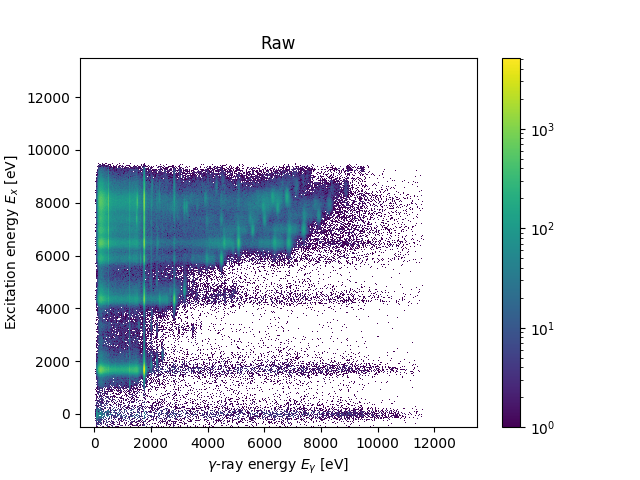

<IPython.core.display.Javascript object>


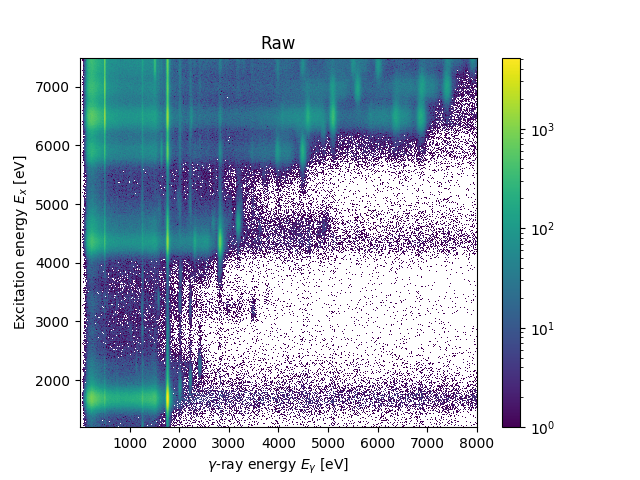

{'a0x': 1201.0, 'a1x': 7.0, 'a0y': 4.0, 'a1y': 7.0} 7.0


In [3]:
# load raw spectrum and response
raw = om.Matrix(path="data/28Si_oscar.m")

raw.remove_negative()
raw.plot()

# cut the array to decrease the computation time
raw.cut("Ex",Emin=1200, Emax=7500)
raw.cut("Eg",Emin=0, Emax=8000)
raw.plot()
raw.save("data/28Si_oscar_cut.m")
print(raw.calibration(), raw.Eg[1]-raw.Eg[0]) 

We denote folded as `fo`, unfolded as `un`, and the response matrix with `R` 

<a id='compare1'></a>
### Comparison 1: No threshold in ompy
Compare spectra generated with mama, no threhold

In [4]:
folderpath = "../ompy/oscar_response/oscar2017_scale1.15"
fwhm_abs=30 # (30/1330 = 2.25%) # Experimental relative FWHM at 1.33 MeV
def unfold_with_threshold(Emin=0, remove_negatives=True):
    raw_cut = raw.copy()
    raw_cut.cut("Eg", Emin=Emin)

    # generate the response with a cut
    response = om.Response(folderpath)
    Rtest_unf_cut, Rtest_tab_unf_cut = response.interpolate(raw_cut.Eg, fwhm_abs=fwhm_abs/10, return_table=True)

    # unfold
    unfolder= om.Unfolder(response=Rtest_unf_cut, num_iter=30)
    unfolder.use_compton_subtraction = False
    unfolder.response_tab = Rtest_tab_unf_cut
    # unfolder.weight_fluctuation = 0.001
    # unfolder.FWHM_tweak_multiplier = {"fe": 1., "se": 1.1,
    #                                      "de": 1.3, "511": 0.9}
    unfolder.remove_negatives = remove_negatives
    ompy_unf_cut = unfolder(raw_cut)
    return ompy_unf_cut, unfolder

In [5]:
ompy_unf, unfolder = unfold_with_threshold(0)
iscores = unfolder.iscores

**Load unfolded spectrum of mama**

In [6]:
# thresholds chosen for unfolding in mama:

# 0 @ 80; otherwise 1

#
#    |           *************************************************
#    |                                                            
# 0.8|                                                            
#    |          *                                                 
# 0.6|                                                            
#    |         *                                                  
# 0.4|                                                            
#    |                                                            
# 0.2|        *                                                   
#    |                                                            
# 0.0|---------.---------.---------.---------.---------.---------.
#    0        100       200       300       400       500   E(keV)

# load the spectrum w
mama_un = om.Matrix(path="data/28Si_oscar_cut_un_neg.m")

# somewhere in the process the binning got messed up
mama_un.Ex = raw.Ex.copy()
# mama_un.Eg = raw.Eg.copy()
mama_un.verify_integrity()

# In mama:
#     - load spectrum that was folded in ompy
#     - create response matrix ("unf." not "view")
#       Note: calibration coefficients here get easily messed up! Check that correct!
#     - unfold, with threshold as shown above
#     - did not delete the negative counts

[1700. 2262. 3302. 4359. 5800. 6200. 6600. 7000. 7400.]


<IPython.core.display.Javascript object>


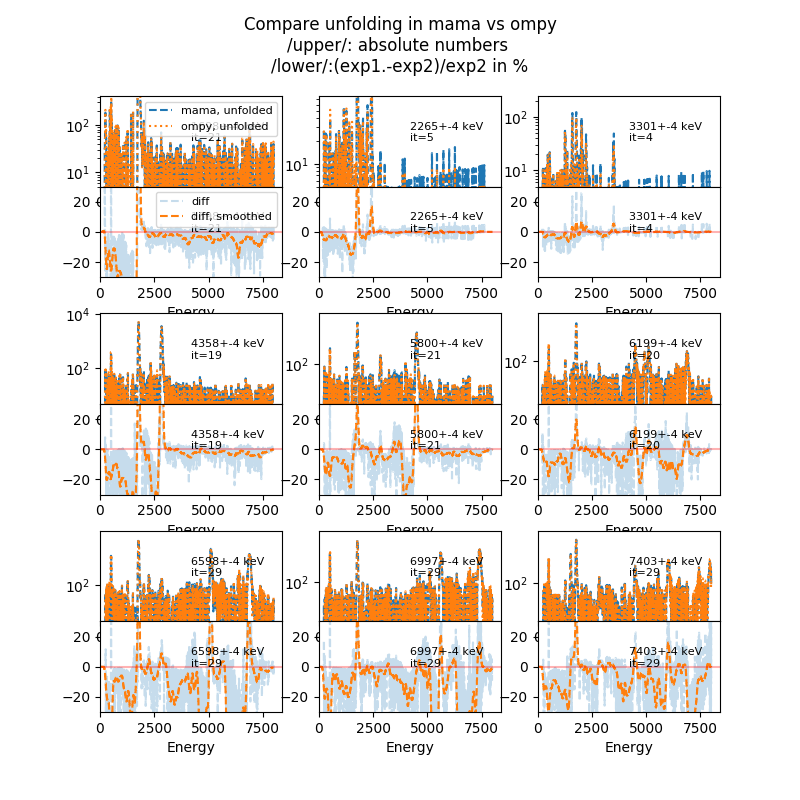

<IPython.core.display.Javascript object>


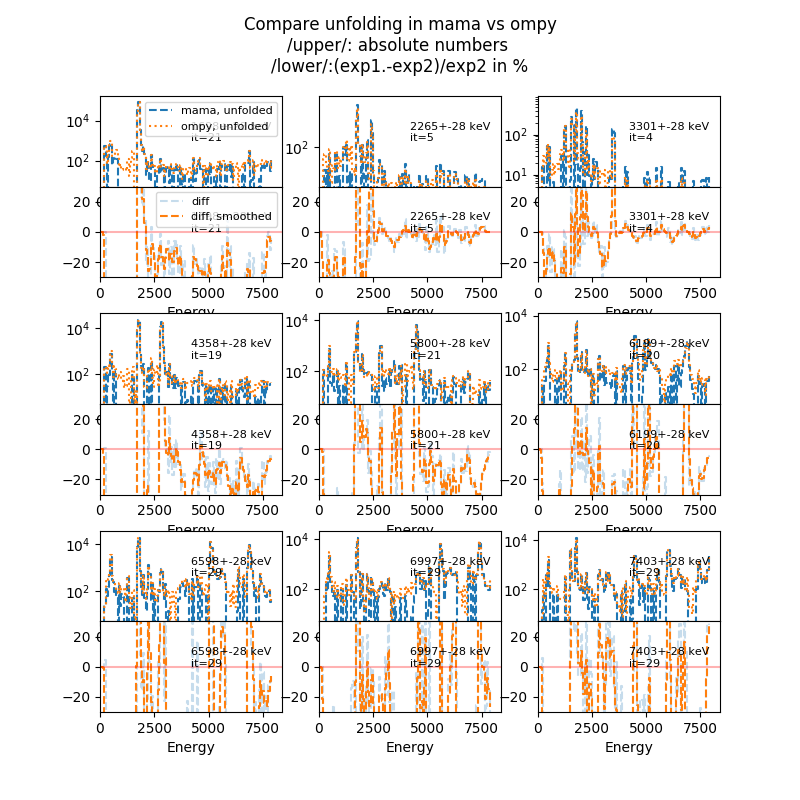

In [7]:
# for the plotting function as of now, we need the same binning of the matrices
# ompy_unf.rebin("Eg", raw.Eg)
# ompy_unf.rebin("Ex", raw.Ex)


E_arr = np.array([1700, 2262, 3302, 4359])
E_arr = np.append(E_arr,np.linspace(5800, 7400, num=5))
print(E_arr)

fig, ax_abs, ax_diff=\
    plot_compare(E_arr, 
                 exp1=mama_un, label1="mama, unfolded", 
                 exp2=ompy_unf, label2="ompy, unfolded",
                 iscores=iscores)
label_ = fig._suptitle.get_text()
fig.suptitle("Compare unfolding in mama vs ompy\n"+label_)
fig.savefig("figs/28Si_unfolded.png")


# rebin also, because this is difficult to see
fig, ax_abs, ax_diff=\
    plot_compare(E_arr, 
                 exp1=mama_un, label1="mama, unfolded", 
                 exp2=ompy_unf, label2="ompy, unfolded",
                 iscores=iscores,
                 rebin_Eg_factor=8)

label_ = fig._suptitle.get_text()
fig.suptitle("Compare unfolding in mama vs ompy\n"+label_)
fig.savefig("figs/28Si_unfolded_rebin8.png")
# fig_diff.suptitle("(unfolded-true)/true in %")

<a id='compare2'></a>
### Comparison 2: 80 keV threshold in ompy

**Unfold in ompy**: Trying to mimic the 80 keV threshold of mama by cutting the raw spectra at 80 keV.

<IPython.core.display.Javascript object>


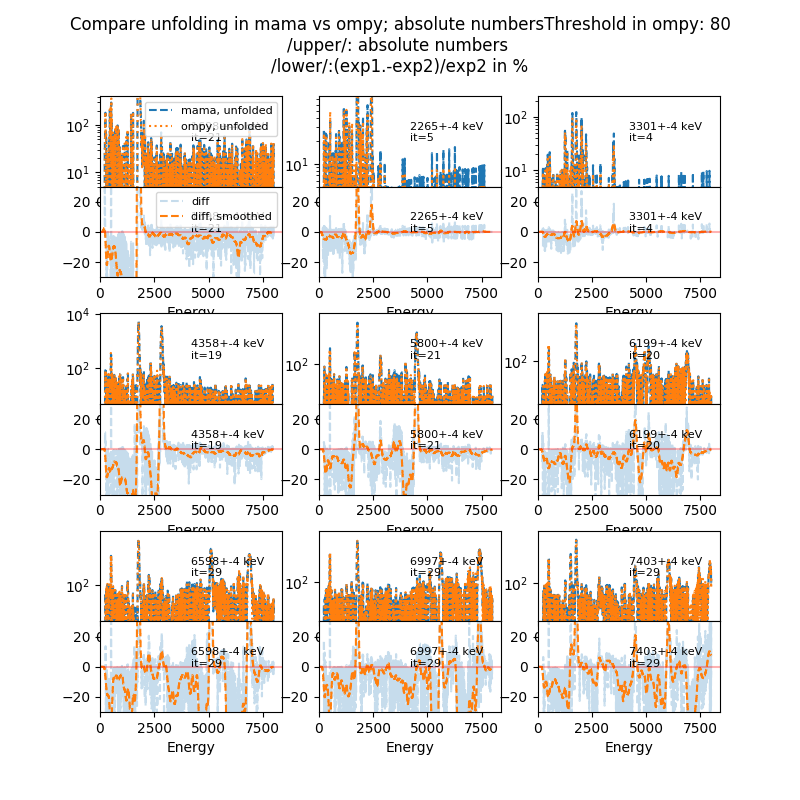

Text(0.5, 0.98, 'Compare unfolding in mama vs ompy; absolute numbersThreshold in ompy: 80\n/upper/: absolute numbers \n/lower/:(exp1.-exp2)/exp2 in %')

In [8]:
Ethreshold = 80
ompy_unf, unfolder = unfold_with_threshold(Ethreshold)
iscores_cut = unfolder.iscores

ompy_unf.rebin("Eg", mama_un.Eg)
ompy_unf.rebin("Ex", mama_un.Ex)

# E_arr = np.linspace(-80, 9500, num=9)
fig, ax_abs, ax_diff =\
    plot_compare(E_arr, 
                 exp1=mama_un, label1="mama, unfolded", 
                 exp2=ompy_unf, label2="ompy, unfolded",
                 iscores=iscores)

label_ = fig._suptitle.get_text()
fig.suptitle("Compare unfolding in mama vs ompy; absolute numbers"
             f"Threshold in ompy: {Ethreshold:.0f}\n"+label_)

<a id='compare3'></a>
### Comparison 3: Folded spectra

In [9]:
Ethreshold = 0
ompy_unf, unfolder = unfold_with_threshold(Ethreshold, remove_negatives=False)
iscores_cut = unfolder.iscores

# fold spectrum
ompy_unf_fo_neg = ompy_unf.copy()
ompy_unf_fo_neg.values = ompy_unf.values@unfolder.R.values

# ompy_unf_fo_neg.rebin("Eg", raw.Eg)
# ompy_unf_fo_neg.rebin("Ex", raw.Ex)
ompy_unf_fo_neg.verify_integrity()

# get folded from mama
mama_un_fo_neg = om.Matrix(path="data/28Si_oscar_cut_un_neg_fo.m")
# somewhere in the process the binning got messed up
mama_un_fo_neg.Ex = raw.Ex.copy()
# mama_un.Eg = raw.Eg.copy()
mama_un_fo_neg.verify_integrity()

If mama overshoots the raw spectrum here at low energies, I think that I've done something slightly wrong how I treat the spectrum in mama. My guesstimate is that I removed the negative counts, even I didn't want to. It at least resembles strongly the effect seen below in  

<IPython.core.display.Javascript object>


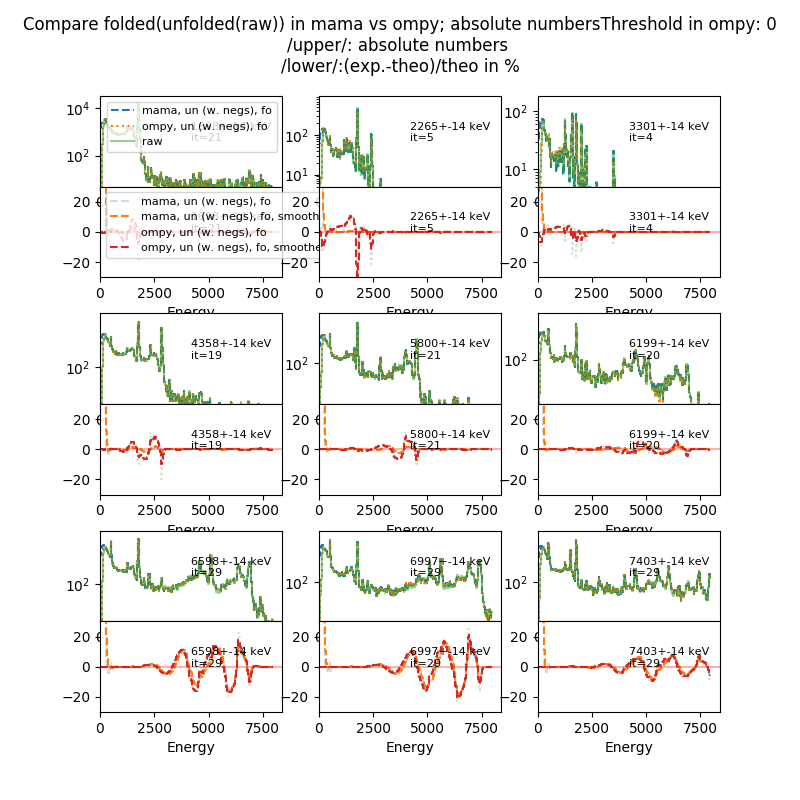

Text(0.5, 0.98, 'Compare folded(unfolded(raw)) in mama vs ompy; absolute numbersThreshold in ompy: 0\n/upper/: absolute numbers \n/lower/:(exp.-theo)/theo in %')

In [10]:

# E_arr = np.linspace(-80, 9500, num=9)
fig, ax_abs, ax_diff =\
    plot_compare(E_arr, 
                 exp1=mama_un_fo_neg, label1="mama, un (w. negs), fo", 
                 exp2=ompy_unf_fo_neg, label2="ompy, un (w. negs), fo",
                 theo=raw, label_teo="raw",
                 iscores=iscores,
                 rebin_Eg_factor=4)

label_ = fig._suptitle.get_text()
fig.suptitle("Compare folded(unfolded(raw)) in mama vs ompy; absolute numbers"
             f"Threshold in ompy: {Ethreshold:.0f}\n"+label_)

<a id='compare4'></a>
### Comparison 4: Folded spectra -- removes negative counts

In [11]:
Ethreshold = 0
ompy_unf, unfolder = unfold_with_threshold(Ethreshold, remove_negatives=True)
iscores_cut = unfolder.iscores

# fold spectrum
ompy_unf_fo_neg = ompy_unf.copy()
ompy_unf_fo_neg.values = ompy_unf.values@unfolder.R.values

# ompy_unf_fo_neg.rebin("Eg", raw.Eg)
# ompy_unf_fo_neg.rebin("Ex", raw.Ex)
ompy_unf_fo_neg.verify_integrity()

# get folded from mama
mama_un_fo_neg = om.Matrix(path="data/28Si_oscar_cut_un_fo.m")
# somewhere in the process the binning got messed up
mama_un_fo_neg.Ex = raw.Ex.copy()
# mama_un.Eg = raw.Eg.copy()
mama_un_fo_neg.verify_integrity()

<IPython.core.display.Javascript object>


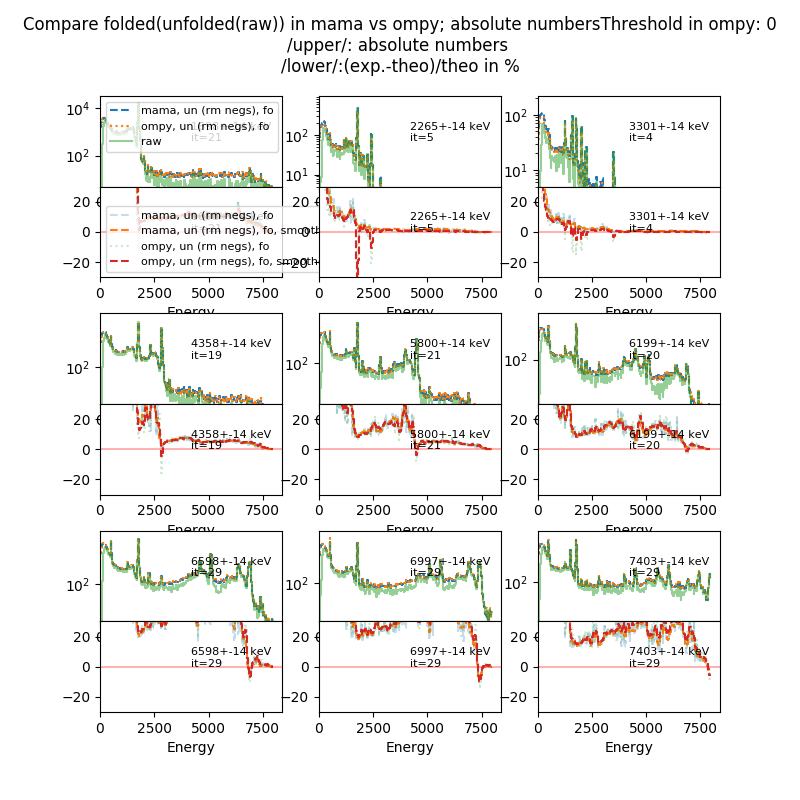

Text(0.5, 0.98, 'Compare folded(unfolded(raw)) in mama vs ompy; absolute numbersThreshold in ompy: 0\n/upper/: absolute numbers \n/lower/:(exp.-theo)/theo in %')

In [12]:

# E_arr = np.linspace(-80, 9500, num=9)
fig, ax_abs, ax_diff =\
    plot_compare(E_arr, 
                 exp1=mama_un_fo_neg, label1="mama, un (rm negs), fo", 
                 exp2=ompy_unf_fo_neg, label2="ompy, un (rm negs), fo",
                 theo=raw, label_teo="raw",
                 iscores=iscores,
                 rebin_Eg_factor=4)

label_ = fig._suptitle.get_text()
fig.suptitle("Compare folded(unfolded(raw)) in mama vs ompy; absolute numbers"
             f"Threshold in ompy: {Ethreshold:.0f}\n"+label_)